In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = pd.read_excel('Faster_Velocities.xlsx', sheet_name=None)

In [3]:
# rejecting first 5 samples in each PWM group
samples_to_reject = 5
px_data = data['Positive X']
py_data = data['Positive Y']
nx_data = data['Negative X']
ny_data = data['Negative Y']
# px_data = pd.concat([group.iloc[samples_to_reject:] for _, group in px_data.groupby('PWM')], ignore_index=True).drop(columns=['Max Value', 'Velocity'])
# py_data = pd.concat([group.iloc[samples_to_reject:] for _, group in py_data.groupby('PWM')], ignore_index=True).drop(columns=['Max Value', 'Velocity'])
# nx_data = pd.concat([group.iloc[samples_to_reject:] for _, group in nx_data.groupby('PWM')], ignore_index=True).drop(columns=['Max Value', 'Velocity'])
# ny_data = pd.concat([group.iloc[samples_to_reject:] for _, group in ny_data.groupby('PWM')], ignore_index=True).drop(columns=['Max Value', 'Velocity'])
px_data = pd.concat([group.iloc[samples_to_reject:] for _, group in px_data.groupby('PWM')], ignore_index=True).drop(columns=['Velocity'])
py_data = pd.concat([group.iloc[samples_to_reject:] for _, group in py_data.groupby('PWM')], ignore_index=True).drop(columns=['Velocity'])
nx_data = pd.concat([group.iloc[samples_to_reject:] for _, group in nx_data.groupby('PWM')], ignore_index=True).drop(columns=['Velocity'])
ny_data = pd.concat([group.iloc[samples_to_reject:] for _, group in ny_data.groupby('PWM')], ignore_index=True).drop(columns=['Velocity'])

In [4]:
# creating data directory if it doesn't exist
import os
if not os.path.exists('data'):
    os.makedirs('data')

## Util Functions

In [5]:
def vis_vels(df, sma, delta_t=0.053, filter='EMA'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    for _, group in df.groupby('PWM'):
        axs[0].plot(np.arange(len(group))*delta_t, group['Velocity_x'])
        axs[1].plot(np.arange(len(group))*delta_t, group['Velocity_y'])
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Velocity (theta/s)')
    axs[0].set_title(f'Velocity in the X direction')

    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Velocity (theta/s)')
    axs[1].set_title(f'Velocity in the Y direction')
    fig.suptitle(f'Velocity for {sma} using {filter} ')
    plt.show()

def extract_max_vel(data_with_vel, column, sgn):
    data_only_vel = (data_with_vel.drop(columns=['X', 'Y', 'DeltaX', 'DeltaY', 'DeltaT', 'Time'])[data_with_vel[column]!=0.0]
                                  .groupby('PWM')
                                  .agg(['max', 'min', 'mean'])
                                  .reset_index())
    data_only_vel.columns = ['_'.join(col) for col in data_only_vel.columns]
    if sgn == '+':
        data_only_vel = data_only_vel.sort_values(by=column+'_max')
    else:
        data_only_vel = data_only_vel.sort_values(by=column+'_min', ascending=False)
    if column == 'Velocity_x':
        if sgn == '+':
            data_only_vel = data_only_vel[['Velocity_x_max', 'Velocity_x_min', 'Velocity_x_mean', 'PWM_']]
        else:
            data_only_vel = data_only_vel[['Velocity_x_min', 'Velocity_x_max', 'Velocity_x_mean', 'PWM_']]
    else:
        if sgn == '+':
            data_only_vel = data_only_vel[['Velocity_y_max', 'Velocity_y_min', 'Velocity_y_mean', 'PWM_']]
        else:
            data_only_vel = data_only_vel[['Velocity_y_min', 'Velocity_y_max', 'Velocity_y_mean', 'PWM_']]
    return data_only_vel

## EMA

- Main Idea is to run EMA on the X and Y values directly, and then find the velocities
- Adjust alpha to change weight of EMA
- Execute cells below to export results into 
  - Vel_EMA.xlsx (the file with all the computed velocities, timestamp etc.)
  - Max_vel_EMA (the file with only the max, min and mean velocities groupby PWM values)

In [6]:
alpha = 0.1

In [7]:
# comput velocities EMA on the X, Y values
def compute_velocities_ema(df, sma, alpha=0.1):
    df = df.copy()
    df['Time'] = df['Time'] / 1000
    dfs = []
    for _, group in df.groupby('PWM'):
        group['X'] = group['X'].ewm(alpha=alpha, adjust=False).mean()
        group['Y'] = group['Y'].ewm(alpha=alpha, adjust=False).mean()
        group['DeltaX'] = group['X'] - group['X'].shift()
        group['DeltaY'] = group['Y'] - group['Y'].shift()
        group['DeltaT'] = group['Time'] - group['Time'].shift()
        group = group.dropna()
        dfs.append(group)
    df = pd.concat(dfs, ignore_index=True)
    # filter delta x and y if they are smaller than 0.6 and set it to 0
    if sma == 'PX':
        df['DeltaX'] = df['DeltaX'].apply(lambda x: 0 if x < 0 else x)
    elif sma == 'PY':
        df['DeltaY'] = df['DeltaY'].apply(lambda x: 0 if x < 0 else x)
    elif sma == 'NX':
        df['DeltaX'] = df['DeltaX'].apply(lambda x: 0 if x > 0 else x)
    elif sma == 'NY':
        df['DeltaY'] = df['DeltaY'].apply(lambda x: 0 if x > 0 else x)
    df['Velocity_x'] = df['DeltaX'] / df['DeltaT']
    df['Velocity_y'] = df['DeltaY'] / df['DeltaT']
    df.loc[df['PWM'] == 0, 'Velocity_x'] = 0
    df.loc[df['PWM'] == 0, 'Velocity_y'] = 0

    return df

In [8]:
px_data.columns

Index(['Time', 'X', 'Y', 'PWM'], dtype='object')

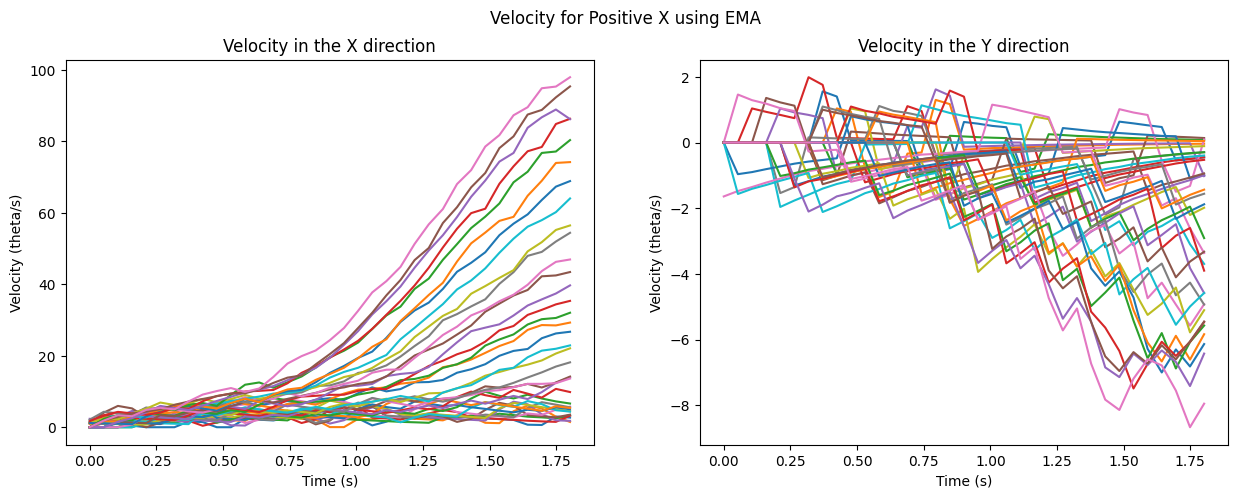

In [9]:
px_data_with_vel =  compute_velocities_ema(px_data, 'PX', alpha=alpha)
vis_vels(px_data_with_vel, 'Positive X')

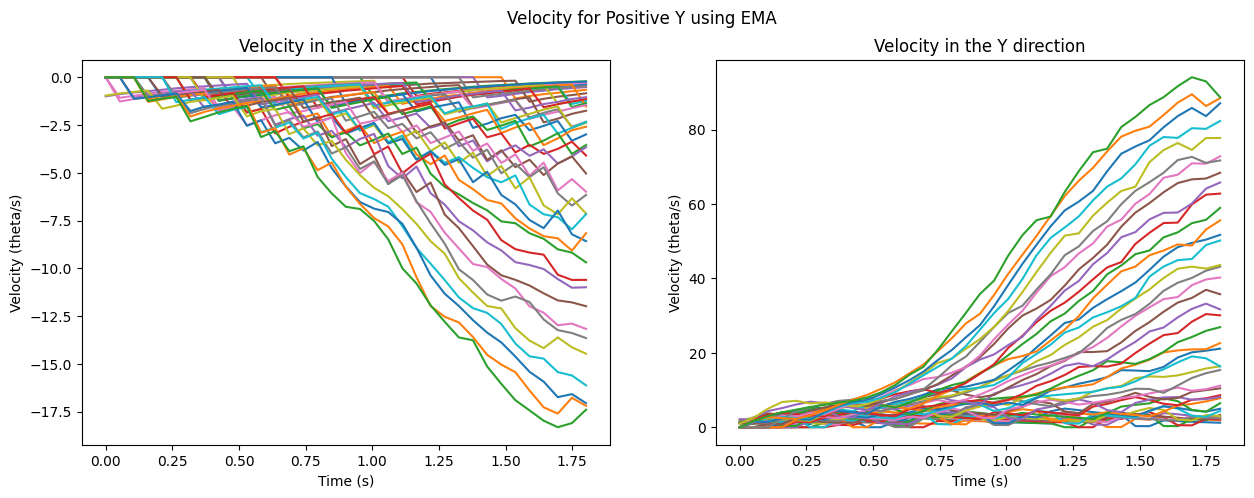

In [10]:
py_data_with_vel =  compute_velocities_ema(py_data, 'PY', alpha=alpha)
vis_vels(py_data_with_vel, 'Positive Y')

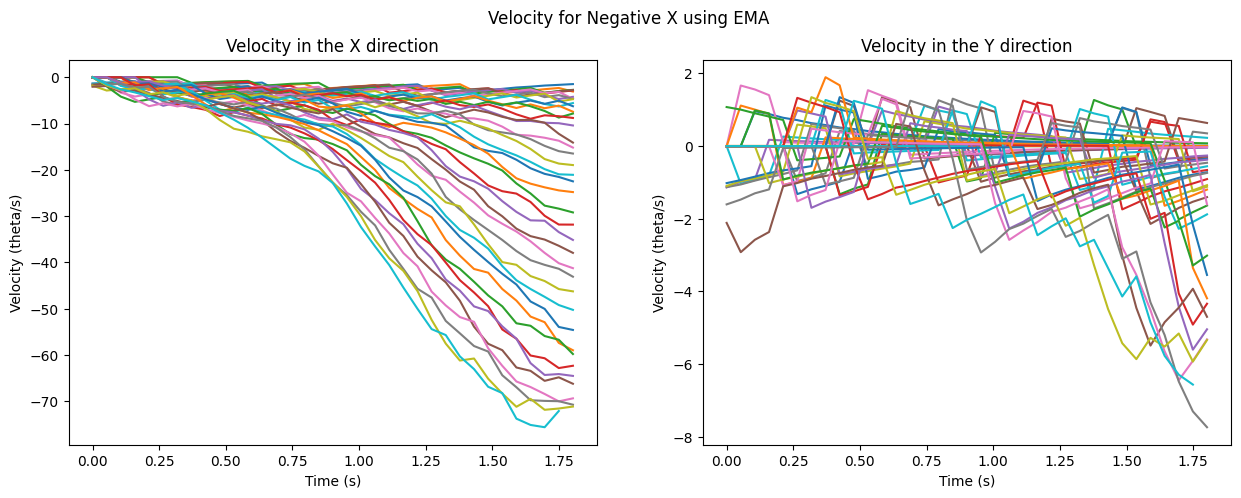

In [11]:
nx_data_with_vel =  compute_velocities_ema(nx_data, 'NX', alpha=alpha)
vis_vels(nx_data_with_vel, 'Negative X')

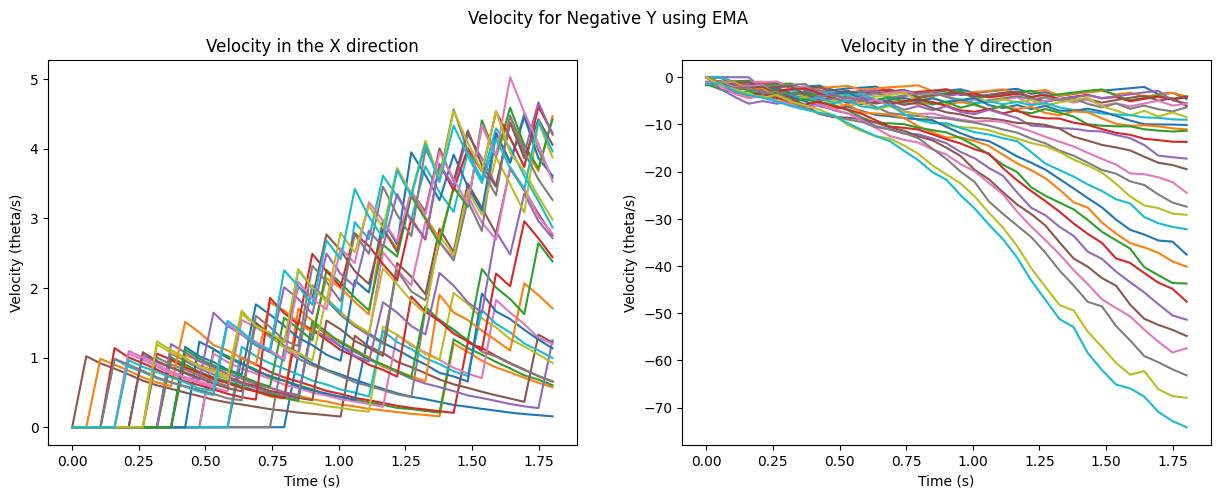

In [12]:
ny_data_with_vel =  compute_velocities_ema(ny_data, 'NY', alpha=alpha)
vis_vels(ny_data_with_vel, 'Negative Y')

In [13]:
with pd.ExcelWriter('./data/Vel_EMA.xlsx') as writer:  
    px_data_with_vel.to_excel(writer, sheet_name='Positive X')
    py_data_with_vel.to_excel(writer, sheet_name='Positive Y')
    nx_data_with_vel.to_excel(writer, sheet_name='Negative X')
    ny_data_with_vel.to_excel(writer, sheet_name='Negative Y')

In [14]:
with pd.ExcelWriter('./data/Max_vel_EMA.xlsx') as writer:  
    extract_max_vel(px_data_with_vel, 'Velocity_x', '+').to_excel(writer, sheet_name='Positive X')
    extract_max_vel(py_data_with_vel, 'Velocity_y', '+').to_excel(writer, sheet_name='Positive Y')
    extract_max_vel(nx_data_with_vel, 'Velocity_x', '-').to_excel(writer, sheet_name='Negative X')
    extract_max_vel(ny_data_with_vel, 'Velocity_y', '-').to_excel(writer, sheet_name='Negative Y')

In [15]:

data_only_vel = extract_max_vel(nx_data_with_vel, 'Velocity_x', '-')
data_only_vel

,Velocity_x_min,Velocity_x_max,Velocity_x_mean,PWM_
1,-3.477504,-0.838042,-2.032606,21
2,-3.527184,-0.794890,-2.091563,22
3,-3.841701,-1.018321,-2.333663,23
0,-3.966987,-0.878926,-2.081486,20
5,-4.214681,-1.096154,-2.537411,25
6,-4.652253,-0.779892,-2.620953,26
4,-4.706744,-0.725621,-2.517639,24
7,-4.867603,-1.488462,-3.135210,27
8,-5.293920,-1.237925,-3.263317,28
10,-6.263597,-0.882692,-3.584147,30


## Rolling Window

- Main Idea is drag a window of a fixed size across the time series, and compute the velocity from the endpoints of the window
- Adjust win_len to change the window size
- Execute cells below to export results into 
  - Vel_rolling_window.xlsx (the file with all the computed velocities, timestamp etc.)
  - Max_vel_rolling_window.xlsx (the file with only the max, min and mean velocities groupby PWM values)

In [16]:
win_len = 10

In [17]:
# comput velocities EMA on the X, Y values
def compute_velocities_rolling_window(df, sma, window_length=3):
    df = df.copy()
    df['Time'] = df['Time'] / 1000
    dfs = []
    for _, group in df.groupby('PWM'):
        group['DeltaX'] = group['X'] - group['X'].shift(window_length)
        group['DeltaY'] = group['Y'] - group['Y'].shift(window_length)
        group['DeltaT'] = group['Time'] - group['Time'].shift(window_length)
        group = group.dropna()
        dfs.append(group)
    df = pd.concat(dfs, ignore_index=True)
    # filter delta x and y if they are smaller than 0.6 and set it to 0
    if sma == 'PX':
        df['DeltaX'] = df['DeltaX'].apply(lambda x: 0 if x < 0 else x)
    elif sma == 'PY':
        df['DeltaY'] = df['DeltaY'].apply(lambda x: 0 if x < 0 else x)
    elif sma == 'NX':
        df['DeltaX'] = df['DeltaX'].apply(lambda x: 0 if x > 0 else x)
    elif sma == 'NY':
        df['DeltaY'] = df['DeltaY'].apply(lambda x: 0 if x > 0 else x)
    df['Velocity_x'] = df['DeltaX'] / df['DeltaT']
    df['Velocity_y'] = df['DeltaY'] / df['DeltaT']
    df.loc[df['PWM'] == 0, 'Velocity_x'] = 0
    df.loc[df['PWM'] == 0, 'Velocity_y'] = 0

    return df

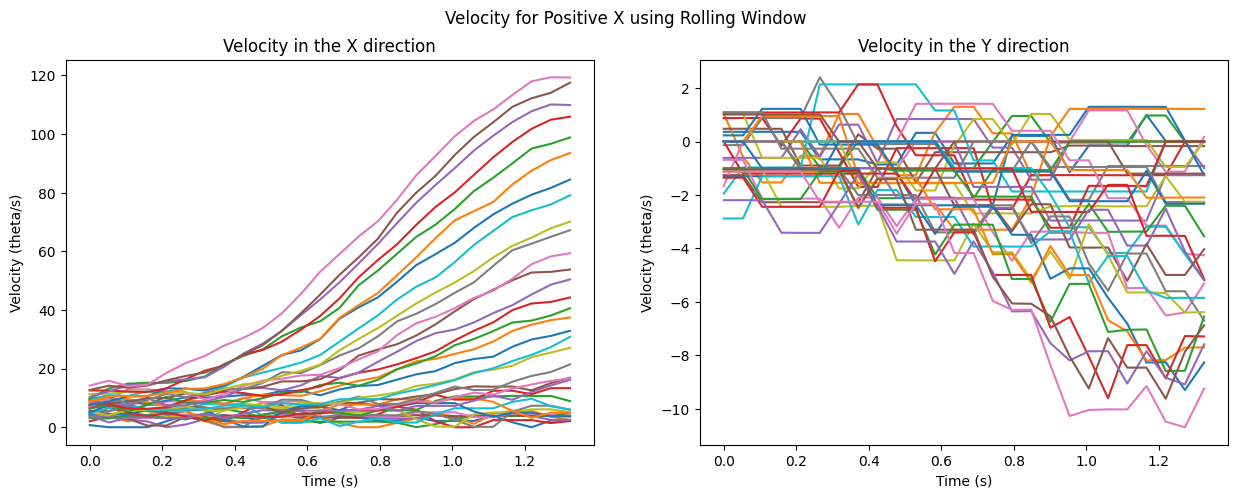

In [18]:
px_data_win =  compute_velocities_rolling_window(px_data, 'PX', window_length=win_len)
vis_vels(px_data_win, 'Positive X', filter='Rolling Window')

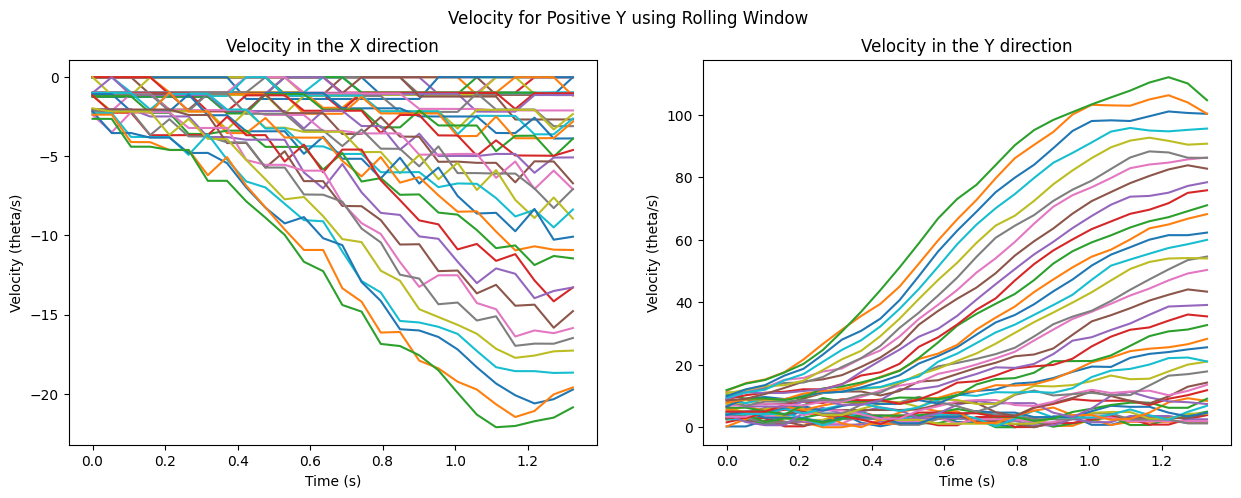

In [19]:
py_data_win =  compute_velocities_rolling_window(py_data, 'PY', window_length=win_len)
vis_vels(py_data_win, 'Positive Y', filter='Rolling Window')

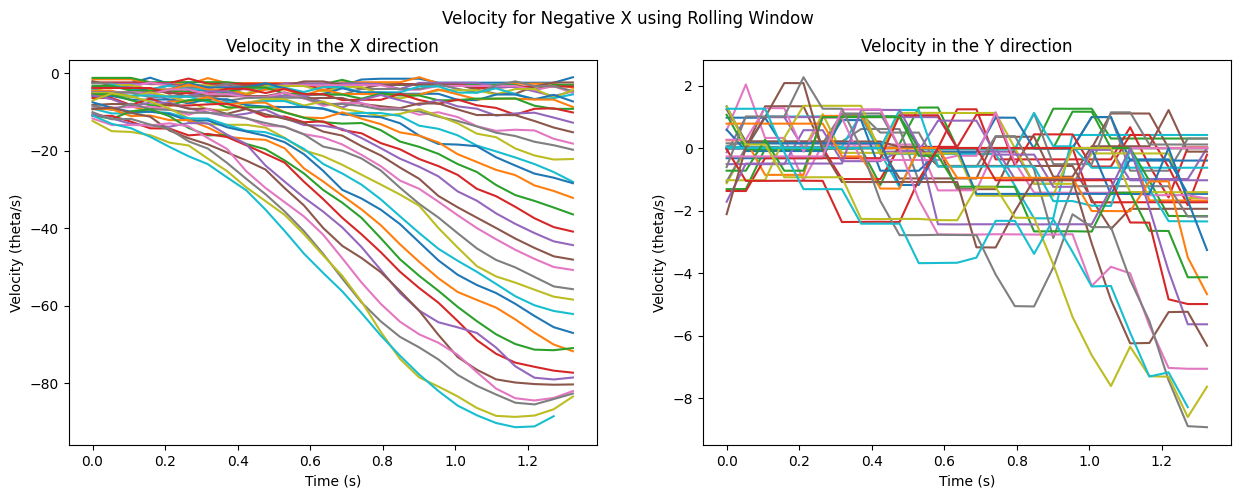

In [20]:
nx_data_win =  compute_velocities_rolling_window(nx_data, 'NX', window_length=win_len)
vis_vels(nx_data_win, 'Negative X', filter='Rolling Window')

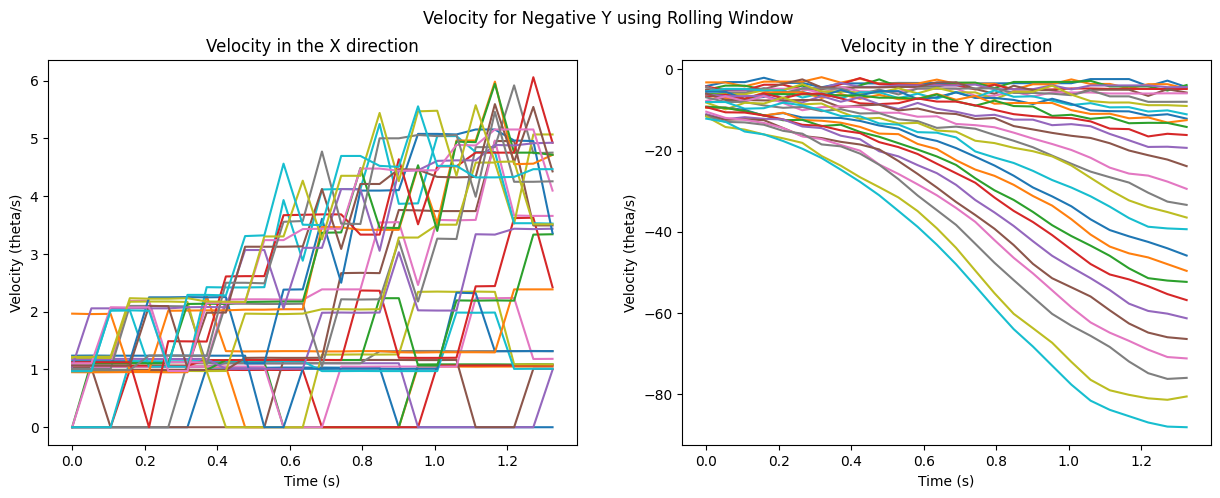

In [21]:
ny_data_win =  compute_velocities_rolling_window(ny_data, 'NY', window_length=win_len)
vis_vels(ny_data_win, 'Negative Y', filter='Rolling Window')

In [22]:
with pd.ExcelWriter('./data/Vel_rolling_window.xlsx') as writer:  
    px_data_win.to_excel(writer, sheet_name='Positive X')
    py_data_win.to_excel(writer, sheet_name='Positive Y')
    nx_data_win.to_excel(writer, sheet_name='Negative X')
    ny_data_win.to_excel(writer, sheet_name='Negative Y')

In [23]:
with pd.ExcelWriter('./data/Max_vel_rolling_win.xlsx') as writer:
    extract_max_vel(px_data_win, 'Velocity_x', '+').to_excel(writer, sheet_name='Positive X')
    extract_max_vel(py_data_win, 'Velocity_y', '+').to_excel(writer, sheet_name='Positive Y')
    extract_max_vel(nx_data_win, 'Velocity_x', '-').to_excel(writer, sheet_name='Negative X')
    extract_max_vel(ny_data_win, 'Velocity_y', '-').to_excel(writer, sheet_name='Negative Y')  

## Decrease Sample Rate

- Main Idea is to decrase the sampling rate by only using every nth datapoint to compute the velocity
  - Can be thought of as a rollig window with win_len of n and stride of n
- Adjust skip to get every "skip"th data point
- Execute cells below to export results into 
  - Vel_decreased_sample.xlsx (the file with all the computed velocities, timestamp etc.)
  - Max_vel_decreased_sample.xlsx (the file with only the max, min and mean velocities groupby PWM values)

In [24]:
skip = 10

In [25]:

def compute_velocities_decrease_samples(df, sma, skip=2):
    df = df.copy()
    df['Time'] = df['Time'] / 1000
    dfs = []
    for _, group in df.groupby('PWM'):
        group = group.iloc[::skip].copy()
        group['DeltaX'] = group['X'] - group['X'].shift()
        group['DeltaY'] = group['Y'] - group['Y'].shift()
        group['DeltaT'] = group['Time'] - group['Time'].shift()
        group = group.dropna()
        dfs.append(group)
    df = pd.concat(dfs, ignore_index=True)
    # filter delta x and y if they are smaller than 0.6 and set it to 0
    if sma == 'PX':
        df['DeltaX'] = df['DeltaX'].apply(lambda x: 0 if x < 0 else x)
    elif sma == 'PY':
        df['DeltaY'] = df['DeltaY'].apply(lambda x: 0 if x < 0 else x)
    elif sma == 'NX':
        df['DeltaX'] = df['DeltaX'].apply(lambda x: 0 if x > 0 else x)
    elif sma == 'NY':
        df['DeltaY'] = df['DeltaY'].apply(lambda x: 0 if x > 0 else x)
    df['Velocity_x'] = df['DeltaX'] / df['DeltaT']
    df['Velocity_y'] = df['DeltaY'] / df['DeltaT']
    df.loc[df['PWM'] == 0, 'Velocity_x'] = 0
    df.loc[df['PWM'] == 0, 'Velocity_y'] = 0

    return df

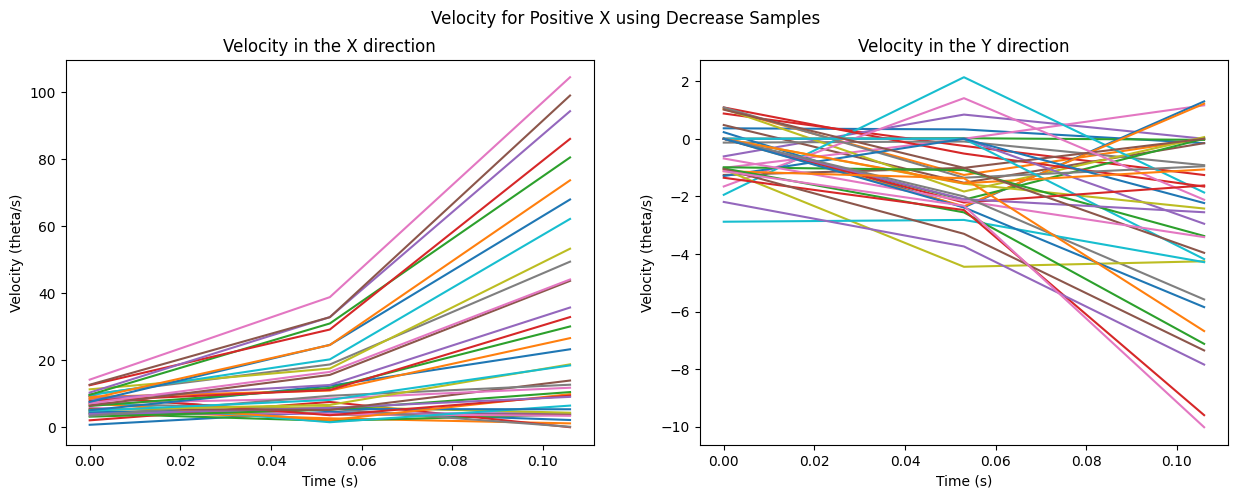

In [26]:
px_data_dec =  compute_velocities_decrease_samples(px_data, 'PX', skip=skip)
vis_vels(px_data_dec, 'Positive X', filter='Decrease Samples')

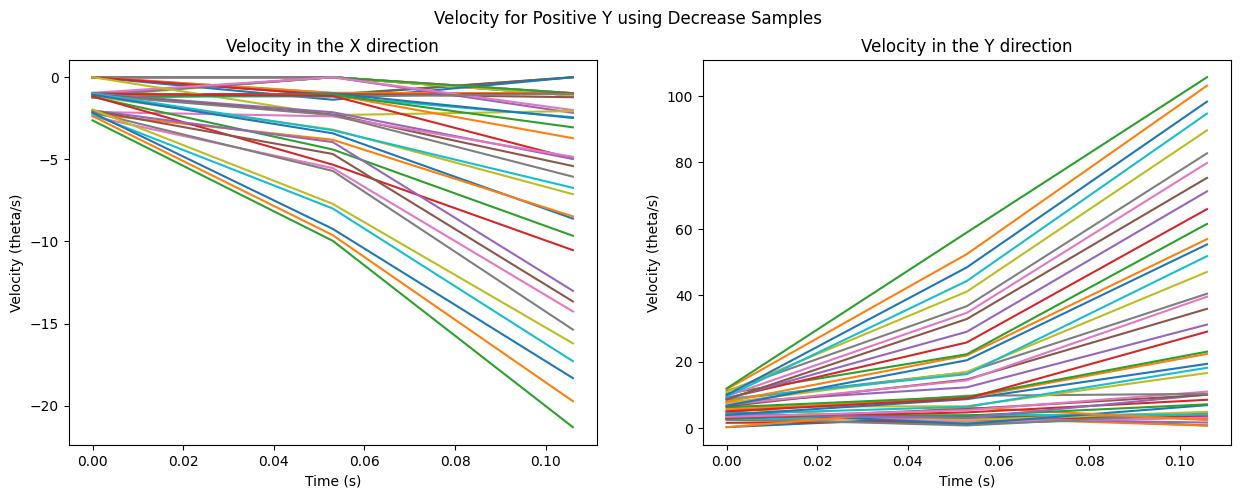

In [27]:
py_data_dec =  compute_velocities_decrease_samples(py_data, 'PY', skip=skip)
vis_vels(py_data_dec, 'Positive Y', filter='Decrease Samples')

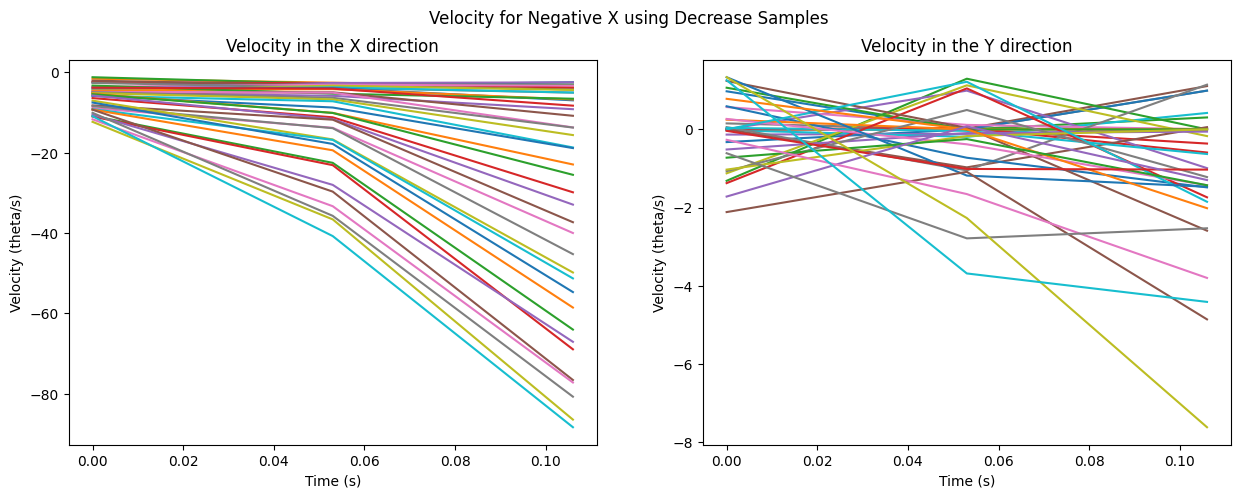

In [28]:
nx_data_dec =  compute_velocities_decrease_samples(nx_data, 'NX', skip=skip)
vis_vels(nx_data_dec, 'Negative X', filter='Decrease Samples')

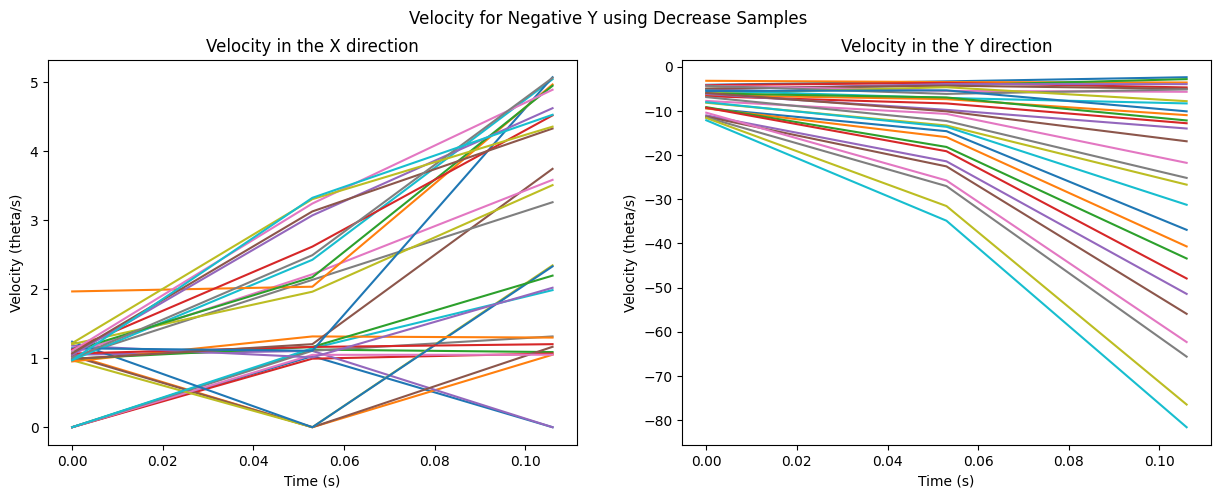

In [29]:
ny_data_dec =  compute_velocities_decrease_samples(ny_data, 'NY', skip=skip)
vis_vels(ny_data_dec, 'Negative Y', filter='Decrease Samples')

In [30]:
with pd.ExcelWriter('./data/Vel_decreased_sample.xlsx') as writer:  
    px_data_dec.to_excel(writer, sheet_name='Positive X')
    py_data_dec.to_excel(writer, sheet_name='Positive Y')
    nx_data_dec.to_excel(writer, sheet_name='Negative X')
    ny_data_dec.to_excel(writer, sheet_name='Negative Y')

In [31]:
with pd.ExcelWriter('./data/Max_vel_decreased_sample.xlsx') as writer: 
    extract_max_vel(px_data_dec, 'Velocity_x', '+').to_excel(writer, sheet_name='Positive X')
    extract_max_vel(py_data_dec, 'Velocity_y', '+').to_excel(writer, sheet_name='Positive Y')
    extract_max_vel(nx_data_dec, 'Velocity_x', '-').to_excel(writer, sheet_name='Negative X')
    extract_max_vel(ny_data_dec, 'Velocity_y', '-').to_excel(writer, sheet_name='Negative Y') 